# Utilizando uma stack científica em Python para a modelagem computacional, calibração e quantificação de incertezas da epidemia do COVID-19

**Diego T. Volpatto**

Laboratório Nacional de Computação Científica

## O que iremos ver hoje?

* Como ler e visualizar dados da COVID-19 com `pandas` e `matplotlib`
* Como implementar um modelo de EDO com a `numpy` e solucioná-lo com a `scipy`
* Como fazer um ajustes de mínimos quadrados de um modelo computacional genérico utilizando *Differential Evolution* da `scipy`
* Como descobrir os parâmetros mais influentes do modelo utilizando o método de *Elementary Effects* com a `SALib`

## O que fica para uma parte 2?

* Como calibrar parâmetros de um modelo com abordagem Bayesiana utilizando o `pymc3`
* Como simular realizações com os parâmetros calibrados em cenários preditivos com o `pymc3` (*forward propagation*)

## E com qual objetivo?

### Contextos

* Entender as tecnologias utilizadas
* Por qual motivo foram aplicadas
* E onde são aplicadas

### Conversar

* Isso não é uma "apresentação", mas sim uma demonstração
* Por favor, **interrompa/participe** sempre que quiser!

## Leitura e pré-tratamento dos dados

## Leitura e pré-tratamento dos dados

### De onde são os dados?
* Importante etapa, visto que os dados de COVID-19 são disponibilizados (às vezes nem sempre) pelo [Ministério da Saúde](https://covid.saude.gov.br/)
* São disponibilizados em formato `csv`

### Como incorporar os dados em Python?

* `pandas` é a sua amiga para essa tarefa
* É uma biblioteca **open source** de **Análise de Dados** bastante respeitada
* Bem otimizada, com partes do processamento implementado em linguagem C

### Vamos ver em ação

* Estrutura básica: `DataFrame`
* Armazena informação tabular
* Capaz de selecionar quais colunas utilizar, ler datas e etc
* Consegue ler vários tipos de arquivos de dados, aqui usamos `pandas.read_csv`

In [1]:
import pandas as pd

import os

pd.options.mode.chained_assignment = None
DATA_PATH = os.environ["DATA_DIR"]

df_brazil_states_cases = pd.read_csv(
    f"{DATA_PATH}/cases-brazil-states.csv",
    usecols=["date", "state", "totalCases", "deaths", "recovered"],
    parse_dates=["date"],
)

df_brazil_states_cases

,date,state,deaths,totalCases,recovered
0,2020-02-25,SP,0,1,NaN
1,2020-02-25,TOTAL,0,1,NaN
2,2020-02-26,SP,0,1,NaN
3,2020-02-26,TOTAL,0,1,NaN
4,2020-02-27,SP,0,1,NaN
...,...,...,...,...,...
1409,2020-05-01,SC,50,2104,NaN
1410,2020-05-01,SE,14,517,45.0
1411,2020-05-01,SP,2511,30374,1524.0
1412,2020-05-01,TO,3,191,31.0


Podemos facilmente tratar e limpar os dados

In [2]:
df_brazil_states_cases.fillna(value={"recovered": 0}, inplace=True)

df_brazil_states_cases = df_brazil_states_cases[df_brazil_states_cases.state != "TOTAL"]

Função para filtrar dados apenas de um certo estado:

In [3]:
def get_brazil_state_dataframe(
    df_brazil: pd.DataFrame, state_name: str, confirmed_lower_threshold: int = 5
) -> pd.DataFrame:
    df_brazil = df_brazil.copy()
    df_state_cases = df_brazil[df_brazil.state == state_name]
    df_state_cases.reset_index(drop=True, inplace=True)
    columns_rename = {"totalCases": "confirmed"}
    df_state_cases.rename(columns=columns_rename, inplace=True)
    df_state_cases["active"] = (
        df_state_cases["confirmed"] - df_state_cases["deaths"] - df_state_cases["recovered"]
    )

    df_state_cases = df_state_cases[df_state_cases.confirmed > confirmed_lower_threshold]
    day_range_list = list(range(len(df_state_cases.confirmed)))
    df_state_cases["day"] = day_range_list
    df_state_cases.reset_index(drop=True, inplace=True)
    
    return df_state_cases

E então, podemos pegar os dados do RJ, por exemplo:

In [4]:
df_rj_state_cases = get_brazil_state_dataframe(df_brazil_states_cases, state_name="RJ")

df_rj_state_cases

,date,state,deaths,confirmed,recovered,active,day
0,2020-03-10,RJ,0,8,0.0,8.0,0
1,2020-03-11,RJ,0,13,0.0,13.0,1
2,2020-03-12,RJ,0,16,0.0,16.0,2
3,2020-03-13,RJ,0,16,0.0,16.0,3
4,2020-03-14,RJ,0,22,0.0,22.0,4
5,2020-03-15,RJ,0,24,0.0,24.0,5
6,2020-03-16,RJ,0,31,0.0,31.0,6
7,2020-03-17,RJ,0,33,0.0,33.0,7
8,2020-03-18,RJ,0,63,0.0,63.0,8
9,2020-03-19,RJ,2,66,0.0,64.0,9


Porém, esses dados estão desatualizados. Vamos ler o `csv` com dados atualizados já tratados:

In [5]:
df_rj_state_cases = pd.read_csv(
    f"{DATA_PATH}/rio_covid19.csv",
    usecols=["date", "day", "cases", "deaths", "recoveries"],
    parse_dates=["date"],
)

columns_rename = {"recoveries": "recovered"}
df_rj_state_cases.rename(columns=columns_rename, inplace=True)

df_rj_state_cases.cases

0           8
1          13
2          16
3          16
4          22
        ...  
188    242810
189    244418
190    246182
191    246843
192    249798
Name: cases, Length: 193, dtype: int64

E facilmente podemos visualizar dados históricos com o `matplotlib`:

In [6]:
time_as_days = df_rj_state_cases.day
confirmed_cases_rj = df_rj_state_cases.cases
deaths_rj = df_rj_state_cases.deaths

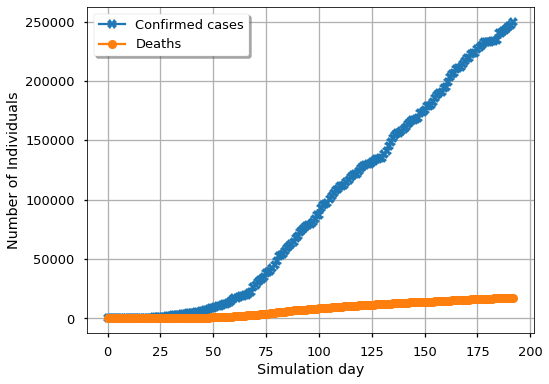

In [7]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-talk")  # beautify the plots!

plt.figure(figsize=(8, 6))

plt.plot(time_as_days, confirmed_cases_rj, "-X", label="Confirmed cases")
plt.plot(time_as_days, deaths_rj, "-o", label="Deaths")

plt.xlabel("Simulation day")
plt.ylabel("Number of Individuals")

plt.legend(shadow=True)
plt.grid(True)

plt.show()

# Perguntas? Comentários?

## Implementando e solucionando EDOs em Python

## Implementando e solucionando EDOs em Python

* Nossos modelos são _locais_ e homogeneizados, representados por Equações Diferenciais Ordinárias.
* Como fazer isso em Python?
* Suas novas amigas (**open source**, nada de black-box): `numpy` e `scipy`
* *Hold my beer*

Como exemplo inicial, vamos considerar um sistema simples e didático: Lotka-Volterra.

O sistema de EDOs é definido como:

\begin{equation}
\left\{
\begin{aligned}
\dot{U} &=r U-a U V \\
\dot{V} &=b a U V - m V
\end{aligned}
\right.
\end{equation}

sendo $U$ a densidade populacional da presa e $V$ a do predador. Os parâmetros são considerados como constantes e $r, a, b, m > 0$.

Para solucionar esse sistema, primeiro devemos definir uma função que represente esse sistema.

Para solucionar esse sistema, primeiro devemos definir uma função que represente esse sistema.

In [8]:
import numpy as np  # já vamos colocar esse cara em campo


def lotka_volterra_system(
    t: float, 
    X: np.ndarray, 
    r: float = 1.5, 
    a: float = 1.0, 
    b: float = 1.0, 
    m: float = 3.0
) -> tuple:
    U, V = X  # unpacking
    
    dUdt = r * U - a * U * V
    dVdt = b * a * U * V - m * V
    
    return dUdt, dVdt

Opcional, porém relevante para alguns casos: `numba`!

In [9]:
from numba import jit

@jit(nopython=True)
def lotka_volterra_system_numba(
    t: float, 
    X: np.ndarray, 
    r: float = 1.5, 
    a: float = 1.0, 
    b: float = 1.0, 
    m: float = 3.0
) -> tuple:
    U, V = X  # unpacking
    
    dUdt = r * U - a * U * V
    dVdt = b * a * U * V - m * V
    
    return dUdt, dVdt

E agora podemos conhecer o solucionador dos nossos problemas: o módulo **integrate** da `scipy`.
Dentro dele, temos o `solve_ivp`, que é o que iremos utilizar.

In [10]:
from scipy.integrate import solve_ivp

help(solve_ivp)

Help on function solve_ivp in module scipy.integrate._ivp.ivp:

solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
    Solve an initial value problem for a system of ODEs.
    
    This function numerically integrates a system of ordinary differential
    equations given an initial value::
    
        dy / dt = f(t, y)
        y(t0) = y0
    
    Here t is a 1-D independent variable (time), y(t) is an
    N-D vector-valued function (state), and an N-D
    vector-valued function f(t, y) determines the differential equations.
    The goal is to find y(t) approximately satisfying the differential
    equations, given an initial value y(t0)=y0.
    
    Some of the solvers support integration in the complex domain, but note
    that for stiff ODE solvers, the right-hand side must be
    complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
    To solve a problem in the complex domain, pass y0 with a co

Definindo os inputs que precisamos:

In [11]:
t_initial = 0.
t_final = 15.
t_span = (t_initial, t_final)

U0 = 10.
V0 = 5.
y0 = np.array([U0, V0])  # um array da numpy... vamos falar um pouco dele

# Opcional, porém útil
num_of_points = 100
t_eval = np.linspace(t_initial, t_final, num_of_points)

Podemos, então, solucionar o problema:

In [12]:
result = solve_ivp(lotka_volterra_system, t_span, y0, t_eval=t_eval, method='LSODA')

E a performance (temporal)?

In [13]:
%%timeit
solve_ivp(lotka_volterra_system, t_span, y0, t_eval=t_eval, method='LSODA')

10.8 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Colhendo os resultados por variável de estado:

In [14]:
simulation_time = result.t
U_solution, V_solution = result.y

Plotando:

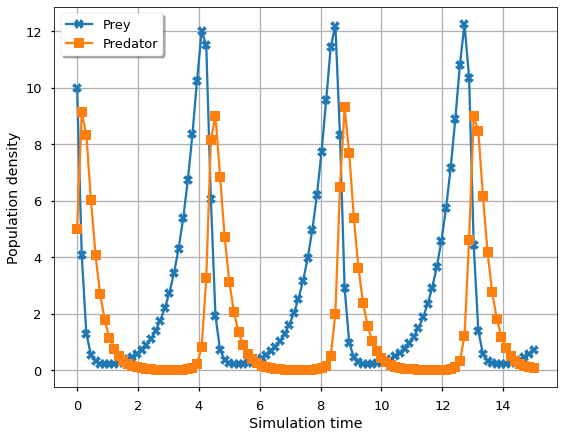

In [15]:
plt.figure(figsize=(9, 7))

plt.plot(simulation_time, U_solution, '-X', label='Prey')
plt.plot(simulation_time, V_solution, '-s', label='Predator')

plt.xlabel("Simulation time")
plt.ylabel("Population density")

plt.legend(shadow=True)
plt.grid(True)

plt.show()

## E para o COVID-19, como fica?

Temos um modelo um tanto quanto mais complicado... mas a adaptação é trivial! Só tem tamanho!

In [16]:
from IPython.display import IFrame
schema_covid = './figures/final_schem_no_eta-crop.pdf'

In [17]:
IFrame(schema_covid, width=900, height=800)

In [18]:
@jit(nopython=True)
def seairpdq_model(
    t,
    X,
    beta0=1e-7,
    beta1=1e-7,
    mu0=1e-7,
    mu1=1e-7,
    gamma_I=0.1,
    gamma_A=0.15,
    gamma_P=0.14,
    d_I=0.0105,
    d_P=0.003,
    omega=1 / 10,
    epsilon_I=1 / 3,
    rho=0.1,
    eta=2e-2,
    sigma=1 / 7,
    N=1,
):
    """
    SEIRPD-Q python implementation.
    """
    S, E, A, I, P, R, D, C, H = X
    beta = beta0
    mu = mu0
    
    # The ODE system
    S_prime = -beta / N * S * I - mu / N * S * A - omega * S + eta * R
    E_prime = beta / N * S * I + mu / N * S * A - sigma * E - omega * E
    A_prime = sigma * (1 - rho) * E - gamma_A * A - omega * A
    I_prime = sigma * rho * E - gamma_I * I - d_I * I - omega * I - epsilon_I * I
    P_prime = epsilon_I * I - gamma_P * P - d_P * P
    R_prime = gamma_A * A + gamma_I * I + gamma_P * P + omega * (S + E + A + I) - eta * R
    D_prime = d_I * I + d_P * P
    # Calibration quantities
    C_prime = epsilon_I * I
    H_prime = gamma_P * P
    return S_prime, E_prime, A_prime, I_prime, P_prime, R_prime, D_prime, C_prime, H_prime

Porém, em vez de usar diretamente o `solve_ivp`, vamos criar um "wrapper", pois será necessário no futuro.

In [19]:
def seairpdq_ode_solver(
    y0,
    t_span,
    t_eval,
    beta0=1e-7,
    omega=1 / 10,
    d_P=9e-3,
    d_I=2e-4,
    gamma_P=1 / 14,
    mu0=1e-7,
    gamma_I=1 / 14,
    gamma_A=1 / 14,
    epsilon_I=1 / 3,
    rho=0.85,
    sigma=1 / 5,
    eta=0,
    N=1,
    beta1=0,
    mu1=0,
):
    mu0 = beta0
    solution_ODE = solve_ivp(
        fun=lambda t, y: seairpdq_model(
            t,
            y,
            beta0=beta0,
            beta1=beta1,
            mu0=mu0,
            mu1=mu1,
            gamma_I=gamma_I,
            gamma_A=gamma_A,
            gamma_P=gamma_P,
            d_I=d_I,
            d_P=d_P,
            omega=omega,
            epsilon_I=epsilon_I,
            rho=rho,
            eta=eta,
            sigma=sigma,
            N=N,
        ),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        method="LSODA",
    )

    return solution_ODE

Dessa forma, podemos resolver o problema passando os parâmetros necessários.

Vamos começar estimando as condições iniciais a partir dos dados:

In [20]:
target_population = rio_population = float(6718903)  # gathered from IBGE 2019
df_target_population = df_rj_state_cases
E0, A0, I0, P0, R0, D0, C0, H0 = (
    int(10 * float(df_target_population.cases.values[0])),
    int(1 * float(df_target_population.cases.values[0])),
    int(5 * float(df_target_population.cases.values[0])),
    int(float(df_target_population.cases.values[0])),
    int(float(df_target_population.recovered.values[0])),
    int(float(df_target_population.deaths.values[0])),
    int(float(df_target_population.cases.values[0])),
    int(float(df_target_population.recovered.values[0])),
)

S0 = target_population - (E0 + A0 + I0 + R0 + P0 + D0)
y0_seairpdq = S0, E0, A0, I0, P0, R0, D0, C0, H0

Temos tudo que é necessário:

In [21]:
t_initial = 0.
t_final = 100.
t_span = (t_initial, t_final)

num_of_points = int(t_final - t_initial)
t_eval = np.linspace(t_initial, t_final, num_of_points)

Solucionando:

Colhendo a solução:

In [22]:
seairpdq_solution = seairpdq_ode_solver(
    y0_seairpdq, 
    t_span, 
    t_eval
)

In [23]:
t_computed_seairpdq = seairpdq_solution.t
(
    S_seairpdq,
    E_seairpdq,
    A_seairpdq,
    I_seairpdq,
    P_seairpdq,
    R_seairpdq,
    D_seairpdq,
    C_seairpdq,
    H_seairpdq,
) = seairpdq_solution.y

Finalmente, os gráficos:

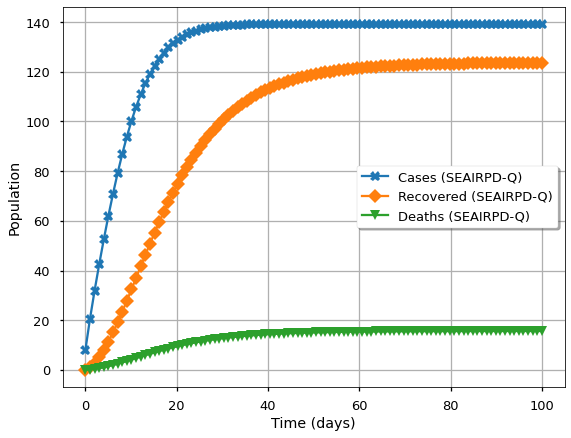

In [24]:
plt.figure(figsize=(9, 7))

plt.plot(
    t_computed_seairpdq,
    C_seairpdq,
    label="Cases (SEAIRPD-Q)",
    marker="X",
    linestyle="-",
    markersize=10,
)

plt.plot(
    t_computed_seairpdq,
    H_seairpdq,
    label="Recovered (SEAIRPD-Q)",
    marker="D",
    linestyle="-",
    markersize=10,
)

plt.plot(
    t_computed_seairpdq,
    D_seairpdq,
    label="Deaths (SEAIRPD-Q)",
    marker="v",
    linestyle="-",
    markersize=10,
)

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend(shadow=True)
plt.grid()

plt.show()

# Perguntas? Comentários?

## Calibração determinística com mínimos quadrados

## Calibração determinística com mínimos quadrados

* Tendo um modelo funcionando, podemos calibrá-lo
* Conciliar dados com a saída de um modelo é solucionar um problema de minimização
* Problemas de otimização possuem ótimos locais e globais
* Como solucionar isso em Python?
* A `scipy` é, novamente, sua amiga

Sendo o ajuste de mínimos quadrados um problema de otimização, qual problema é esse (e a função-objetivo)? Consiste em minimizar o resíduo entre a saída do modelo e os dados observados, satisfazendo as restrições do espaço paramétrico viável.

\begin{equation}
\begin{aligned}
\min_{\theta}{F(t; \theta)} &:= w \frac{1}{N_d} \sum_{i}^{N_d} (y_i^{obs} - y^{model}(t_i, \theta))^2
\end{aligned}
\end{equation}

No nosso caso, consideramos duas saídas do modelo, que são o número de casos confirmados acumulados ($C$) e o número de óbitos total ($D$). Então,

\begin{equation}
\begin{aligned}
\min_{\theta}{F(t; \theta)} &:= \frac{1}{N_d}\left(w_C \sum_{i}^{N_d} [C_i^{obs} - C^{model}(t_i, \theta)]^2 
 + w_D \sum_{i}^{N_d} [D_i^{obs} - D^{model}(t_i, \theta)]^2 \right)
\end{aligned}
\end{equation}

E em Python? Bom, temos que definir a função-objetivo:

\begin{equation}
\begin{aligned}
F(t; \theta) &:= \frac{1}{N_d} \left( w_C \sum_{i}^{N_d} [C_i^{obs} - C^{model}(t_i, \theta)]^2 
 + w_D \sum_{i}^{N_d} [D_i^{obs} - D^{model}(t_i, \theta)]^2 \right)
\end{aligned}
\end{equation}

In [25]:
def seairpdq_least_squares_error_ode(
    parameters, time_exp, f_exp, fitting_model, initial_conditions
):
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1 = 1.0
    weighting_for_exp2 = 1.0
    num_of_points = len(f_exp1)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *parameters)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        (
            _,
            _,
            _,
            _,
            _,
            _,
            simulated_qoi2,  # D
            simulated_qoi1,  # C
            _,
        ) = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1  # Cases
        residual2 = f_exp2 - simulated_qoi2  # Deaths

        first_term = weighting_for_exp1 * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2 * np.sum(residual2 ** 2.0)
        
        objective_function = 1 / num_of_points * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

Como vamos utilizar o *Differential Evolution*, o próximo passo é definir os intervalos de buscas dos parâmetros:

In [26]:
bounds_seirpdq = [
    (0, 1e-5),  # beta
    (0, 1),  # omega
    (0.1, 1e-5),  # d_P
    (0.1, 1e-5),  # d_I
    # (1 / 21, 1 / 14),  # gamma_P
]

E definir os valores observados que serão utilizados:

In [27]:
data_time = df_target_population.day.values.astype(np.float64)  # tem que ser em float
dead_individuals = df_target_population.deaths.values  # .values converte para np.array
confirmed_cases = df_target_population.cases.values

Vamos utilizar uma função de callback para monitorar o método:

In [28]:
def callback_de(xk, convergence):
    print(f"parameters = {xk}\n")

Agora com todos os ingredientes, vamos solucionar o problema utilizando a `scipy.optimize.differential_evolution`:

In [29]:
from scipy import optimize

seed = 1234  # para reprodutividade
result_seirpdq = optimize.differential_evolution(
    seairpdq_least_squares_error_ode,  # função-objetivo
    bounds=bounds_seirpdq,  # hipercubo dos intervalos viáveis
    args=(
        data_time,  # time_exp
        [confirmed_cases, dead_individuals],  # f_exp
        seairpdq_ode_solver,  # fitting_model
        y0_seairpdq,  # initial_conditions
    ),
    # Parâmetros do DE
    popsize=20,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=10000,
    polish=False,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,  # processamento paralelo com tudo que tiver
)

result_seirpdq

/home/diego/.local/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:497: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 7.41489e+09
parameters = [7.50027368e-06 4.00687580e-01 6.35359213e-03 1.90026945e-02]

differential_evolution step 2: f(x)= 7.41489e+09
parameters = [7.50027368e-06 4.00687580e-01 6.35359213e-03 1.90026945e-02]

differential_evolution step 3: f(x)= 7.0163e+09
parameters = [5.83719746e-06 3.31600706e-01 2.30020826e-02 2.63434713e-02]

differential_evolution step 4: f(x)= 6.43018e+09
parameters = [3.12646740e-06 2.34612537e-01 1.14747373e-02 1.43849465e-02]

differential_evolution step 5: f(x)= 6.35243e+09
parameters = [2.99286591e-06 2.28245368e-01 5.61847329e-03 2.20604632e-02]

differential_evolution step 6: f(x)= 6.35243e+09
parameters = [2.99286591e-06 2.28245368e-01 5.61847329e-03 2.20604632e-02]

differential_evolution step 7: f(x)= 6.2114e+09
parameters = [2.07142528e-06 1.82504661e-01 4.87395070e-03 3.26828877e-03]

differential_evolution step 8: f(x)= 6.2114e+09
parameters = [2.07142528e-06 1.82504661e-01 4.87395070e-03 3.26828877e-03]

dif

differential_evolution step 67: f(x)= 8.14911e+07
parameters = [9.89030859e-08 7.18297792e-03 3.38026344e-04 2.43098512e-02]

differential_evolution step 68: f(x)= 8.14901e+07
parameters = [9.89075470e-08 7.18323123e-03 3.32285441e-04 2.43419398e-02]

differential_evolution step 69: f(x)= 8.149e+07
parameters = [9.89001420e-08 7.18258381e-03 3.23288280e-04 2.43073365e-02]

differential_evolution step 70: f(x)= 8.149e+07
parameters = [9.89001420e-08 7.18258381e-03 3.23288280e-04 2.43073365e-02]

differential_evolution step 71: f(x)= 8.149e+07
parameters = [9.89001420e-08 7.18258381e-03 3.23288280e-04 2.43073365e-02]

differential_evolution step 72: f(x)= 8.14899e+07
parameters = [9.88995549e-08 7.18255781e-03 3.19364572e-04 2.43160248e-02]

differential_evolution step 73: f(x)= 8.14895e+07
parameters = [9.89016563e-08 7.18250172e-03 3.15574116e-04 2.43224115e-02]

differential_evolution step 74: f(x)= 8.14893e+07
parameters = [9.89085765e-08 7.18316456e-03 3.22745027e-04 2.43562787e-02]

     fun: 81488823.82621399
 message: 'Optimization terminated successfully.'
    nfev: 6640
     nit: 82
 success: True
       x: array([9.89121734e-08, 7.18343721e-03, 3.23935381e-04, 2.43625338e-02])

Pegando os resultados:

In [30]:
(
    beta_deterministic,
    omega_deterministic,
    d_P_deterministic,
    d_I_deterministic,
) = result_seirpdq.x

print(f"beta = {beta_deterministic:.3e}")
print(f"omega = {omega_deterministic:1.4f}")
print(f"d_P = {d_P_deterministic:.3e}")
print(f"d_I = {d_I_deterministic:.3e}")

beta = 9.891e-08
omega = 0.0072
d_P = 3.239e-04
d_I = 2.436e-02


Vamos realizar uma simulação com os valores desses parâmetros ajustados e comparar com os dados:

In [31]:
t0 = data_time.min()
tf = data_time.max()

solution_ODE_seairpdq = seairpdq_ode_solver(y0_seairpdq, (t0, tf), data_time, *result_seirpdq.x)
t_computed_seairpdq, y_computed_seairpdq = solution_ODE_seairpdq.t, solution_ODE_seairpdq.y
(
    S_seairpdq,
    E_seairpdq,
    A_seairpdq,
    I_seairpdq,
    P_seairpdq,
    R_seairpdq,
    D_seairpdq,
    C_seairpdq,
    H_seairpdq,
) = y_computed_seairpdq

Visualizando:

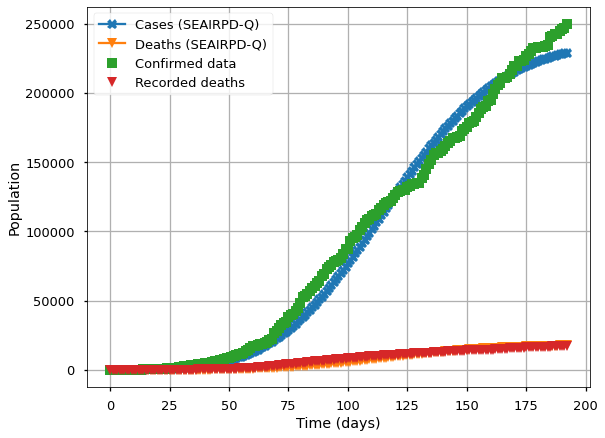

In [32]:
plt.figure(figsize=(9, 7))

plt.plot(
    t_computed_seairpdq,
    C_seairpdq,
    label="Cases (SEAIRPD-Q)",
    marker="X",
    linestyle="-",
    markersize=10,
)

plt.plot(
    t_computed_seairpdq,
    D_seairpdq,
    label="Deaths (SEAIRPD-Q)",
    marker="v",
    linestyle="-",
    markersize=10,
)

plt.plot(
    data_time, confirmed_cases, label="Confirmed data", marker="s", linestyle="", markersize=10
)

plt.plot(
    data_time, dead_individuals, label="Recorded deaths", marker="v", linestyle="", markersize=10
)

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid()

plt.show()

De maneira análoga, poderíamos utilizar os parâmetros calibrados para extrapolar/predizer uma determinada quantidade de dias:

In [33]:
num_of_days_to_predict = 100
t0 = data_time.min()
tf = data_time.max() + num_of_days_to_predict
time_range = np.linspace(t0, tf, int(tf - t0) + 1)

solution_ODE_seairpdq_predicted = seairpdq_ode_solver(y0_seairpdq, (t0, tf), time_range, *result_seirpdq.x)
t_predicted_seairpdq, y_predicted_seairpdq = solution_ODE_seairpdq_predicted.t, solution_ODE_seairpdq_predicted.y
(
    S_seairpdq,
    E_seairpdq,
    A_seairpdq,
    I_seairpdq,
    P_seairpdq,
    R_seairpdq,
    D_seairpdq,
    C_seairpdq,
    H_seairpdq,
) = y_predicted_seairpdq

Visualizando:

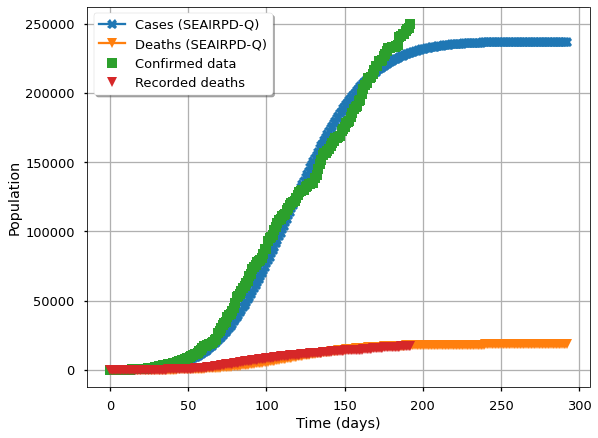

In [34]:
plt.figure(figsize=(9, 7))

plt.plot(
    t_predicted_seairpdq,
    C_seairpdq,
    label="Cases (SEAIRPD-Q)",
    marker="X",
    linestyle="-",
    markersize=10,
)

plt.plot(
    t_predicted_seairpdq,
    D_seairpdq,
    label="Deaths (SEAIRPD-Q)",
    marker="v",
    linestyle="-",
    markersize=10,
)

plt.plot(
    data_time, confirmed_cases, label="Confirmed data", marker="s", linestyle="", markersize=10
)

plt.plot(
    data_time, dead_individuals, label="Recorded deaths", marker="v", linestyle="", markersize=10
)

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend(shadow=True)
plt.grid()

plt.show()

# Perguntas? Comentários?

## Análise de Sensibilidade

## Análise de Sensibilidade

* De posse de um modelo, podemos determinar quais parâmetros são mais influentes levando em conta uma QoI
* Possíveis benefícios:
    * Reduz custos computacionais (menor número de parâmetros a calibrar)
    * Facilita o processo de calibração (identificação do modelo, redundância e etc)
    * Informações e interpretações adicionais do modelo
* É possível fazer isso em Python também?!
* Time to shine, `SALib` (Sensitivity Analysis Library in Python)

Para a Análise de Sensibilidade, utilizamos o método de *Elementary Effects* (ou método de Morris). De maneira bem simplista, é um método que simula planejamento experimental para um modelo computacional. Na `SALib`, ele é feito em duas etapas:

1. Geração das amostras e trajetórias (uma série de perturbações nos parâmetros) utilizando estratégia OAT (One-factor-At-a-Time)
\begin{equation}
d_{i}(\mathbf{X})=\frac{y\left(X_{1}, \ldots, X_{i}+\Delta, \ldots, X_{k}\right)-y(\mathbf{X})}{\Delta}
\end{equation}
2. Análise estatística dos efeitos elementares das perturbações (média e desvio-padrão). Rankear os parâmetros de maneira mais clara e intuitiva, utilizamos o a média normalizada das distribuições dos valores absolutos (para evitar cancelamentos) dos efeitos elementares ($s^*_i$)
\begin{equation}
\begin{aligned}
s_{i}^{*}=& \frac{1}{r} \sum_{j=1}^{r}\left|d_{i}\left(\mathbf{X}^{(j)}\right)\right| \\
\bar{s}_{i}^{*} &=\frac{s_{i}^{*}}{\sum_{l=1}^{k} s_{l}^{*}}
\end{aligned}
\end{equation}

Para gerar as amostras do espaço de experimentação, precisamos informar a média dos valores dos parâmetros e sua faixa de valores (gera uma uniforme utilizando trajetórias e níveis):

In [35]:
# beta0=1e-7,
# omega=1 / 10,
# d_P=9e-3,
# d_I=2e-4,
# gamma_P=1 / 14,
# mu0=1e-7,
# gamma_I=1 / 14,
# gamma_A=1 / 14,
# epsilon_I=1 / 3,
# rho=0.85,
# sigma=1 / 5,
# eta=0

In [36]:
from SALib.sample.morris import sample as ee_sample

gamma_I_deterministic = 1 / 14
gamma_A_deterministic = 1 / 14
gamma_P_deterministic = 1 / 14
epsilon_I_deterministic = 1 / 3
rho_deterministic = 0.85
sigma_deterministic = 1 / 5
eta_deterministic = 0

mean_values_params = [
    beta_deterministic, 
    omega_deterministic, 
    d_P_deterministic, 
    d_I_deterministic,
    gamma_P_deterministic,
    beta_deterministic,
    gamma_I_deterministic,
    gamma_A_deterministic,
    epsilon_I_deterministic,
    rho_deterministic,
    sigma_deterministic
]
factors_names = [
    r'$\beta$', 
    r'$\omega$', 
    r'$d_P$', 
    r'$d_I$', 
    r'$\gamma_P$', 
    r'$\mu$', 
    r'$\gamma_I$', 
    r'$\gamma_A$', 
    r'$\epsilon_I$', 
    r'$\rho$', 
    r'$\sigma$'
]
params_perturbations = 0.25
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 40
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

Com a amostragem dos parâmetros gerada, são feitas as realizações do modelo e computados os efeitos elementares. Para exemplificar, vamos considerar nossa QoI como o número de casos confirmados acumulados para cada dia.

In [37]:
t0 = data_time.min()
tf = data_time.max()
num_of_experimental_points = data_time.shape[0]
num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_experimental_points])

for realization_index, parameters_realization in enumerate(parameter_values):
    
    realization_ODE_seairpdq = seairpdq_ode_solver(y0_seairpdq, (t0, tf), data_time, *parameters_realization)
    (
        S_seairpdq, 
        E_seairpdq,
        A_seairpdq,
        I_seairpdq,
        P_seairpdq,
        R_seairpdq,
        D_seairpdq,
        C_seairpdq,
        H_seairpdq,
    ) = realization_ODE_seairpdq.y
    
    qoi_sensitivity_outputs[realization_index, :] = C_seairpdq

Colhendo e tratando os resultados:

In [38]:
from SALib.analyze.morris import analyze as ee_analyze

Si_list = list()
df_Si = pd.DataFrame(columns=['Time (days)', *problem_info['names']])
df_Si['Time (days)'] = data_time
for experimental_point in range(num_of_experimental_points):
    Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs[:, experimental_point], num_levels=grid_level, seed=seed)
    Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
    Si_list.append(Si)
    for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[experimental_point, param_name] = Si['mu_star_normalized'][idx]

df_Si.sort_values(by='Time (days)', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si

,Time (days),$\beta$,$\omega$,$d_P$,$d_I$,$\gamma_P$,$\mu$,$\gamma_I$,$\gamma_A$,$\epsilon_I$,$\rho$,$\sigma$
1,1.0,0.0166715,0.00282906,3.47047e-09,0.00826457,7.83456e-06,0,0.0227338,6.75496e-05,0.685826,0.137916,0.125683
2,2.0,0.0493075,0.0050498,9.38692e-10,0.0126052,1.63113e-06,0,0.0349877,0.000358698,0.501205,0.213101,0.183384
3,3.0,0.0860937,0.0071013,5.40571e-09,0.0152203,9.6075e-07,0,0.0427025,0.00093343,0.383736,0.253649,0.210564
4,4.0,0.123435,0.00920434,6.96518e-10,0.0170498,7.86653e-07,0,0.0484621,0.00175454,0.302649,0.273685,0.223759
5,5.0,0.160405,0.0114337,2.36934e-09,0.0185082,1.37769e-06,0,0.0534243,0.00278934,0.242511,0.280458,0.230468
...,...,...,...,...,...,...,...,...,...,...,...,...
188,188.0,0.259246,0.100768,1.41549e-06,0.0075923,0.000269704,0,0.0553036,0.00656876,0.0722155,0.473085,0.0249509
189,189.0,0.25926,0.100786,1.52264e-06,0.00759399,0.000269566,0,0.0552911,0.00660614,0.0723224,0.472905,0.0249644
190,190.0,0.259274,0.100804,1.62266e-06,0.00759558,0.000269424,0,0.0552793,0.00664267,0.0724276,0.472729,0.0249771
191,191.0,0.259287,0.100821,1.71472e-06,0.00759711,0.000269254,0,0.0552682,0.0066784,0.072531,0.472557,0.0249892


Visualizando:

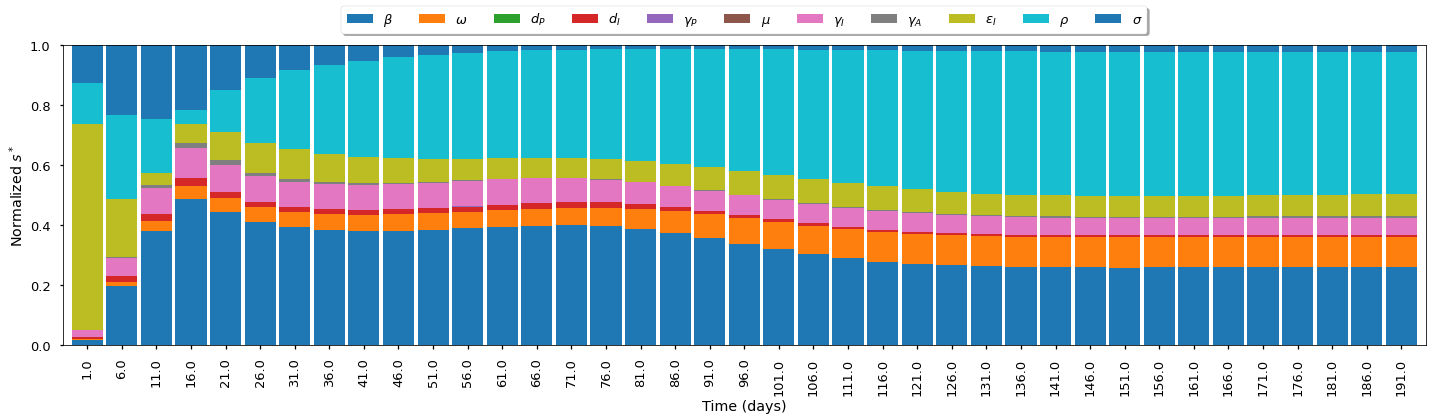

In [39]:
fig = plt.figure()
ax = plt.subplot(111)
day_step_to_plot = 5
df_Si[::day_step_to_plot].plot.bar(x='Time (days)', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
plt.ylabel(r"Normalized $s^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

## Perguntas? Comentários?

## Calibração Bayesiana com o PyMC3

### Calibração Bayesiana com o PyMC3

* Temos um modelo computacional e acesso a seus diversos fatores
* Temos dados observados
* Podemos realizar, com Python, uma calibração Bayesiana do modelo para estimar as incertezas?
* Sim, e aqui é onde o `PyMC3` entra na roda!

### Ingredientes (em termos de modelagem computacional)

Os requerimentos são diferentes em relação a calibrações determinísticas:

* Fundamentalmente, as simulações de Monte Carlo "solucionam" o teorema de Bayes para as *posterioris*
\begin{equation}
\pi_{\text {posterior}}(\boldsymbol{\theta} \mid \boldsymbol{y})=\frac{\pi_{\text {likelihood}}(\boldsymbol{y} \mid \boldsymbol{\theta}) \pi_{\text {prior }}(\boldsymbol{\theta})}{\pi_{\text {evidence}}(\boldsymbol{y})}
\end{equation}

* Para realizar as simulações de Monte Carlo e obter as posterioris, devemos fornecer (com base no nosso conhecimento do problema) as *prioris* dos parâmetros e a *likelihood* das observações. No nosso caso:
\begin{equation}
\pi_{\text {likelihood}}(\boldsymbol{y} \mid \boldsymbol{\theta})=\prod_{j \in\{C, D\}} \frac{1}{\sigma_{j} \sqrt{2 \pi}} \exp \left(-\frac{1}{2} \sum_{i=1}^{n}\left(\frac{y^{(j)}\left(t_{i}\right)-y_{\text {model }}^{(j)}\left(t_{i}\right)}{\sigma_{j}}\right)^{2}\right)
\end{equation}

* Novamente, devemos mapear as estimativas do modelo com os dados observados

### Ingredientes (em termos de implementação)

E o que necessitamos, em termos de código, para rodar uma calibração Bayesiana com o `PyMC3`?

* Devemos possuir uma função que "rode" nosso modelo e tenha a saída alinhada com os dados observados

* Essa função deve ser capaz de parametrizar a simulação pelos fatores do modelo

* Em suma, precisamos de um *wrapper* para a simulação determinística (tipo *black-box*). Algo como

```python
def simulation_wrapper(parameter_1, parameter_2, ...):
    ...
    return simulation_result
```
com `simulation_result` alinhado com os dados observados.

Para fins didáticos, vamos antes ver antes como seria com um exemplo simples: isso mesmo, Lotka-Volterra. Sistema presa-predados com Lince (predador) e Lebres (presa), com dados da Hudson's Bay Company.

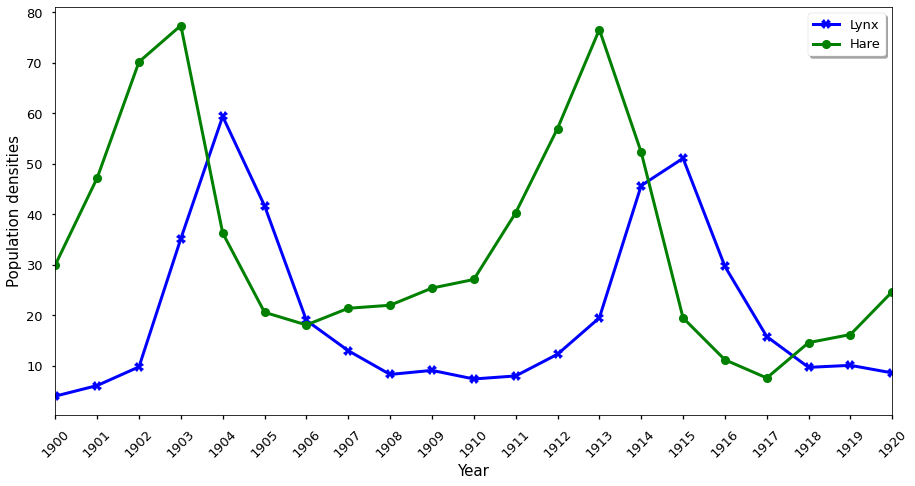

In [41]:
years = np.arange(1900, 1921, 1)
lynx_data = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
hare_data = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])

plt.figure(figsize=(15, 7.5))
plt.plot(years, lynx_data, '-X', color='b', lw=3, label='Lynx')
plt.plot(years, hare_data, '-o', color='g', lw=3, label='Hare')
plt.xlim([1900, 1920])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Population densities', fontsize=15)
plt.xticks(years, rotation=45)
plt.legend(shadow=True)
plt.show()

Agora precisamos implementar o *wrapper*. Mais precisamente, precisamos definir um Custom `OP` com `theano`:

In [47]:
import theano  # to control better pymc3 backend and write a wrapper
import theano.tensor as t  # for the wrapper to a custom model to pymc3

@theano.compile.ops.as_op(
    itypes=[t.dvector, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar], otypes=[t.dmatrix]
)
def lotka_volterra_ode_wrapper(time_exp, r, a, b, m, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r, a, b, m]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        lotka_volterra_system, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

Finalmente, podemos implementar a calibração com o `pymc3`:

In [48]:
import pymc3 as pm  # for uncertainty quantification and model calibration
import time  # vamos monitorar o tempo de execução

observations_to_fit = np.vstack([hare_data, lynx_data]).T
years = np.arange(1900, 1921, 1, dtype=np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 2000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as model_mcmc:
    # Prior distributions for the model's parameters
    r = pm.Uniform(
        "r", 
        lower=0, 
        upper=2,
    )
    a = pm.Uniform(
        "a", 
        lower=0, 
        upper=2,
    )
    b = pm.Uniform(
        "b", 
        lower=0, 
        upper=2,
    )
    m = pm.Uniform(
        "m", 
        lower=0, 
        upper=2,
    )
    
    # Prioris for Initial Conditions
    u0 = pm.Uniform(
        "u0",
        # Veja no gráfico dos dados
        lower=20, 
        upper=50,
    )
    v0 = pm.Uniform(
        "v0",
        # Veja no gráfico dos dados
        lower=0, 
        upper=10,
    )

    standard_deviation = pm.Uniform("std_deviation", lower=1e-5, upper=2, shape=2)  # note 'shape' here

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "lotka_volterra_model",
        lotka_volterra_ode_wrapper(
            theano.shared(years),
            r,
            a,
            b,
            m,
            u0,
            v0
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )

    seirdpq_trace_calibration = pm.sample_smc(
        draws=draws, n_steps=25, parallel=True, cores=4, progressbar=True, random_seed=seed
    )

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Sample initial stage: ...


KeyboardInterrupt: 

## Predições com incertezas nos parâmetros utilizando o PyMC3

## Considerações finais